In [2]:
import cv2

In [3]:
%load_ext autoreload
# %autoreload 2

In [4]:
%autoreload 2
from reconstruct import get_from_mat, correct_image, iradon_centered, find_visual_best

In [5]:
! ls ../data/2018_11005553_syn033_68R_Mg10Gd_12w

angles.mat	  reco_000405.tif  reco_001105.tif
figures		  reco_000505.tif  reco_001205.tif
offset_shift.mat  reco_000605.tif  reco_rawBin2.log
reco_000005.tif   reco_000705.tif  sino_middle_shift_corrected.tif
reco_000105.tif   reco_000805.tif  sino_rawBin2
reco_000205.tif   reco_000905.tif
reco_000305.tif   reco_001005.tif


In [6]:
! cat ../data/2018_11005553_syn033_68R_Mg10Gd_12w/reco_rawBin2.log

scan_name : syn033_68R_Mg10Gd_12w
beamtime_id : 11005553
scan_path : /asap3/petra3/gpfs/p05/2018/data/11005553/raw/syn033_68R_Mg10Gd_12w/
reco_path : /asap3/petra3/gpfs/p05/2018/data/11005553/processed/syn033_68R_Mg10Gd_12w/reco/
MATLAB notation, index of first element: 1, range: first:stride:last
MATLAB version : 9.4.0.813654 (R2018a)
Git commit ID : 1c434c0287733cf0eb70f4eab90e99578bca0d1b
platform : GLNXA64
effective_pixel_size : 1.28114 micron
effective_pixel_size_binned : 2.56228 micron
energy : 35000 eV
sample_detector_distance : 0.007026 m
camera : KIT
exposure_time : 96.000000
num_dark_found : 10
num_ref_found : 240
num_ref_used : 240
ref_range : 1:1:240
num_proj_found : 3001
num_proj_used : 3001
proj_range : 1:1:3001
im_shape_raw : 5120 3840
raw_roi :  
image_shape_roi : 5120 3840
image_shape_roi_binned : 2560 1920
raw_binning_factor : 2
bin_before_filtering : 1
ring_current_normalization : 1
image_correlation.method : ssim-ml
image_correlation.num_flats : 1
image_correlation.

In [7]:
angles = get_from_mat("../data/2018_11005553_syn033_68R_Mg10Gd_12w/angles.mat")
shifts = 1.5 * get_from_mat("../data/2018_11005553_syn033_68R_Mg10Gd_12w/offset_shift.mat")

In [8]:
shifts.shape

(1, 3001)

In [125]:
angles.max() /  np.pi

7.998667110963013

In [10]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_tiffs_from_folder(path='../data/2018_11005553_syn033_68R_Mg10Gd_12w/sino_rawBin2'):
    tiffs = []
    for tiff_file in tqdm(sorted([os.path.join(path, file) for file in os.listdir(path)])):
        tiffs.append(correct_image(np.array(Image.open(tiff_file)), shifts))
    return np.array(tiffs)

In [ ]:
tiffs = get_tiffs_from_folder()

 23%|██▎       | 111/476 [02:04<06:52,  1.13s/it]

In [19]:
tiffs.shape

(476, 3001, 2460)

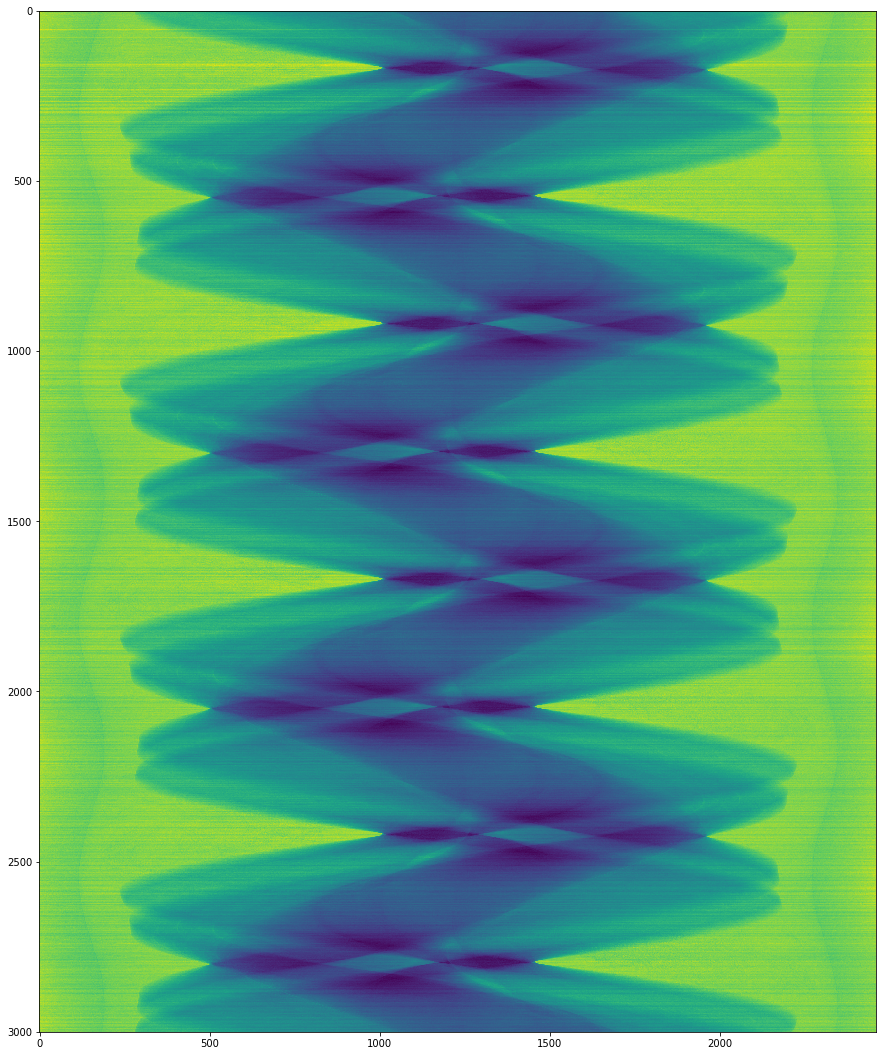

In [20]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[-1])
# plt.imsave()

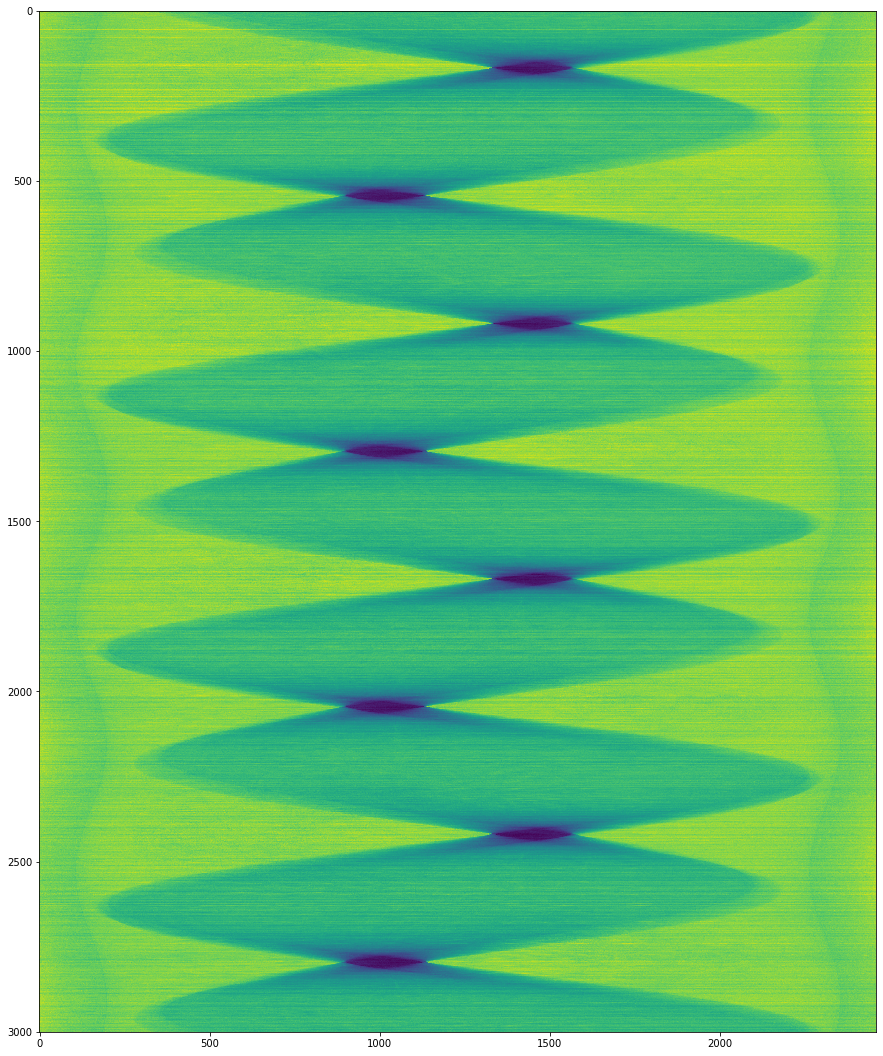

In [21]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[1])

## Take need axes

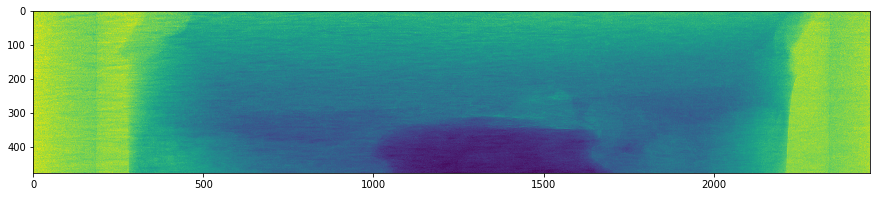

In [22]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[:,0, :])
# plt.imsave('left.png', tiffs[:,0, :])

In [23]:
np.where(angles.squeeze() * 180 / np.pi >= 180)[0][0]

376

In [24]:
(angles.squeeze() * 180 / np.pi)[375]

179.94001999333554

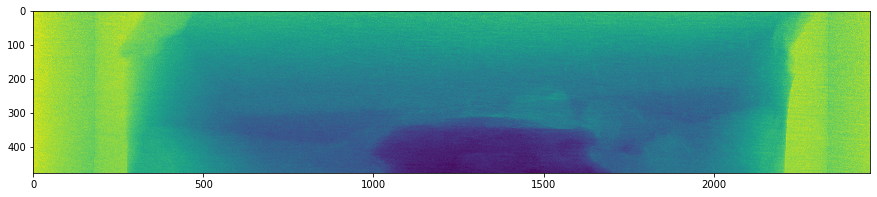

In [25]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[:,376, ::-1])
# plt.imsave('right.png',tiffs[:,376, ::-1])

Если сравнить как раз кажется виден этот нужный сдвиг!

In [32]:
# TBD:

def convert2uint8(img):
    return ((img - img.min()) / img.max() * 255).astype('uint8')

In [33]:
i = 5

In [34]:
left = convert2uint8(tiffs[:,0+i, :])
right = convert2uint8(tiffs[:,376+i, ::-1])

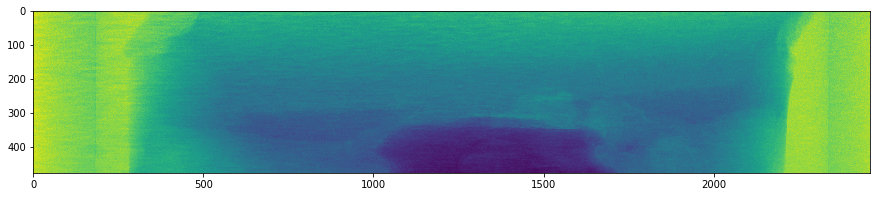

In [35]:
plt.figure(figsize=(15, 20))
plt.imshow(left)
# plt.imsave('left.png', left)

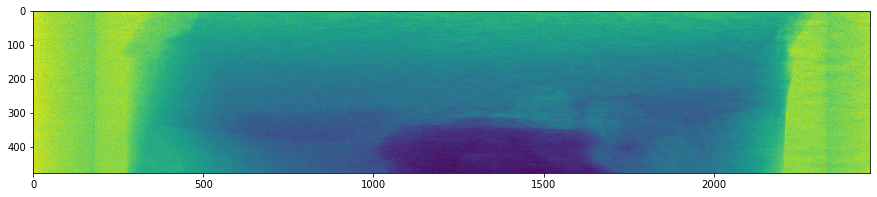

In [36]:
plt.figure(figsize=(15, 20))
plt.imshow(right)
# plt.imsave('right.png', right)

## Find minimal sums over availble shift axes (it works!)

In [37]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [53]:
def find_with_mse(left, right, shift = 15, use_pad=False, use_spline_minima=True, loss='l2', ignore_percent=0):
    best_id = 0
    temp_sum_arr = []
    for i in range(-shift, shift):
        if use_pad:
            if i < 0:
                left_temp = np.hstack([np.full((left.shape[0], abs(i)), left.mean()), left[:, :-abs(i)]])
            else:
                left_temp = np.hstack([left[:, abs(i):], np.full((left.shape[0], abs(i)), left.mean())])
        else:
            left_temp = left[:,i + shift:i - shift].copy()
        right_temp = right[:, shift:-shift].copy()
        if ignore_percent > 0:
            right_temp[:, int(right_temp.shape[1] / 2 * (1 - ignore_percent / 2)):int(right_temp.shape[1] / 2 * (ignore_percent / 2 + 1))] = 0
            left_temp[:, int(left_temp.shape[1] / 2 * (1 - ignore_percent / 2)):int(left_temp.shape[1] / 2 * (ignore_percent / 2 + 1))] = 0
        if loss == 'l2':
            temp_sum = (np.square(right_temp - left_temp)).mean()
        else:
            temp_sum = (np.abs(right_temp - left_temp)).mean()
        temp_sum_arr.append(temp_sum)
    if use_spline_minima:
        x_axis = np.arange(-shift, shift)
        f = InterpolatedUnivariateSpline(x_axis, np.array(temp_sum_arr), k=4)
        cr_pts = f.derivative().roots()
        cr_pts = np.append(cr_pts, (x_axis[0], x_axis[-1]))  # also check the endpoints of the interval
        cr_vals = f(cr_pts)
        min_index = np.argmin(cr_vals)
        max_index = np.argmax(cr_vals)
#         print(cr_pts, cr_vals)
        min_point = cr_pts[min_index]
    else:
        min_point = np.argmin(temp_sum_arr) - shift
    return min_point, np.array(temp_sum_arr)

## Sanity check

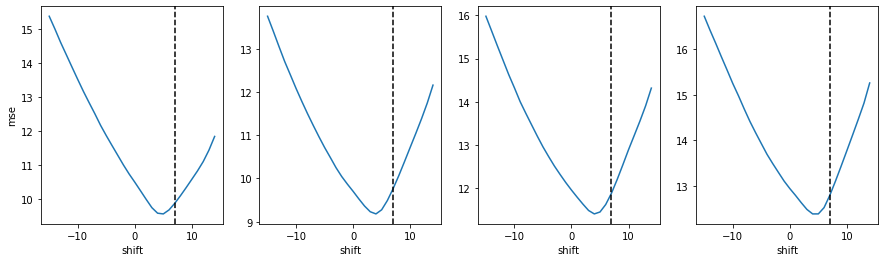

In [54]:
shift = 15
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
ids = []
for ax_id, i in enumerate(range(0, 20, 5)):
    ax = axs[ax_id]
    left = convert2uint8(tiffs[:,0+i, :])
    right = convert2uint8(tiffs[:,376+i, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    ids.append(best_id)
    ax.plot(np.arange(-shift, shift), temp_sum_arr)
    if ax_id == 0:
        ax.set_ylabel('mse')
    ax.axvline(x=3.5 * 2, color='k', linestyle='--')
    ax.set_xlabel('shift')

In [55]:
np.array(ids) / 2

array([2.31931859, 1.94282534, 2.08895487, 2.25480297])

## Run massive tests

In [127]:
converted_angles = angles.squeeze() * 180 / np.pi

In [128]:
shift = 15
predictions = []
for i in range(tiffs.shape[1]):
    left = convert2uint8(tiffs[:,i, :])
    try:
        aligned_id = np.where(converted_angles >= 180 + converted_angles[i])[0][0]
    except IndexError:
        break
    right = convert2uint8(tiffs[:,aligned_id, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = -np.array(predictions) / 2

Text(0.5, 1.0, 'l2-based pipeline')

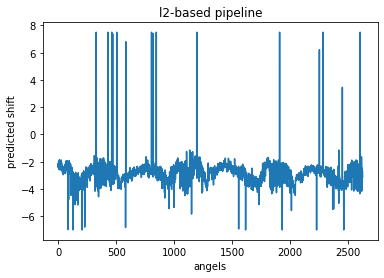

In [129]:
plt.plot(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')

In [130]:
np.mean(predictions)

-2.8186405569881194

In [131]:
np.std(predictions)

0.9830108311865481

(array([1.200e+01, 4.700e+01, 1.453e+03, 1.096e+03, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.400e+01]),
 array([-7.  , -5.55, -4.1 , -2.65, -1.2 ,  0.25,  1.7 ,  3.15,  4.6 ,
         6.05,  7.5 ]),
 <a list of 10 Patch objects>)

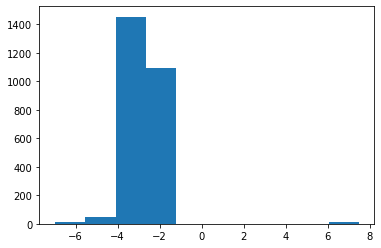

In [132]:
plt.hist(predictions)

## Run massive tests with a neigthbour ideal image - left

In [82]:
shift = 15
predictions = []
for i in range(tiffs.shape[1]):
    left = convert2uint8(tiffs[:,i, :])
    try:
        aligned_id = np.where(converted_angles >= 180 + converted_angles[i])[0][0]
    except IndexError:
        break
    right = convert2uint8(tiffs[:,aligned_id - 1, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = -np.array(predictions) / 2

Text(0.5, 1.0, 'l2-based pipeline')

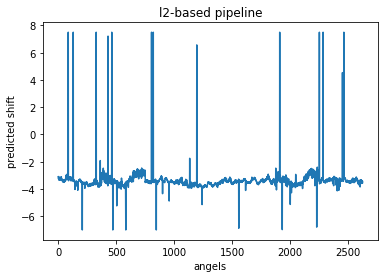

In [83]:
plt.plot(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')

In [84]:
np.mean(predictions)

-3.3722512950659533

In [85]:
np.std(predictions)

0.8158181683573668

(array([7.000e+00, 1.000e+01, 2.552e+03, 4.300e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.200e+01]),
 array([-7.  , -5.55, -4.1 , -2.65, -1.2 ,  0.25,  1.7 ,  3.15,  4.6 ,
         6.05,  7.5 ]),
 <a list of 10 Patch objects>)

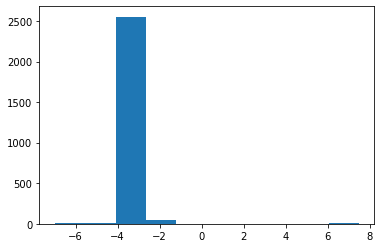

In [86]:
plt.hist(predictions)

## Run massive tests with a neigthbour ideal image - right

In [87]:
shift = 15
predictions = []
for i in range(tiffs.shape[1]):
    left = convert2uint8(tiffs[:,i, :])
    try:
        aligned_id = np.where(converted_angles >= 180 + converted_angles[i])[0][0]
    except IndexError:
        break
    right = convert2uint8(tiffs[:,aligned_id + 1, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = -np.array(predictions) / 2

IndexError: index 3001 is out of bounds for axis 1 with size 3001

Text(0.5, 1.0, 'l2-based pipeline')

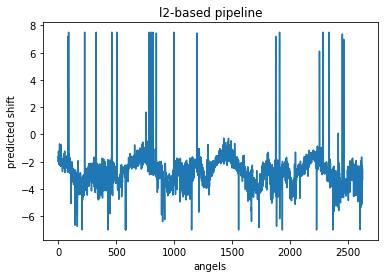

In [90]:
plt.plot(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')

In [91]:
np.mean(predictions)

-2.6824927472693894

In [92]:
np.std(predictions)

1.3023293903242692

(array([2.800e+01, 2.110e+02, 9.920e+02, 1.297e+03, 7.500e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+01]),
 array([-7.  , -5.55, -4.1 , -2.65, -1.2 ,  0.25,  1.7 ,  3.15,  4.6 ,
         6.05,  7.5 ]),
 <a list of 10 Patch objects>)

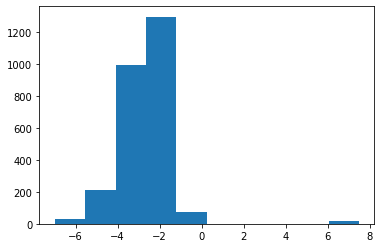

In [93]:
plt.hist(predictions)

## Run massive tests with a best fitted

In [133]:
shift = 25
predictions = []
for i in range(tiffs.shape[1]):
    left = convert2uint8(tiffs[:,i, :])
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = convert2uint8(tiffs[:,aligned_id, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [155]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [156]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 3.431934328814179 standart error: 0.003949754399024832


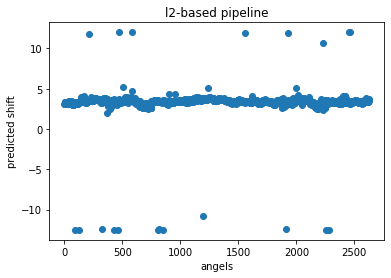

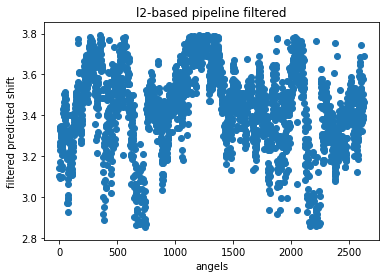

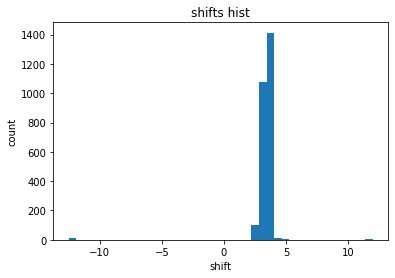

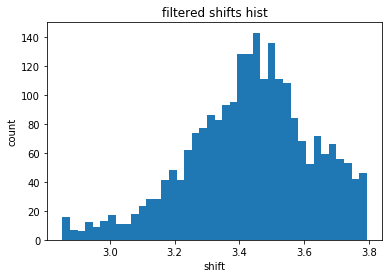

In [157]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Run massive tests with a best fitted without normalization

In [158]:
shift = 25
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [159]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [160]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 3.408906466162831 standart error: 0.0038977449402148234


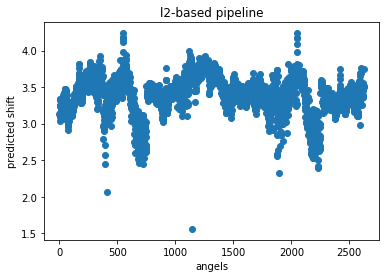

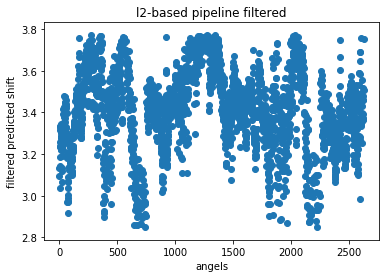

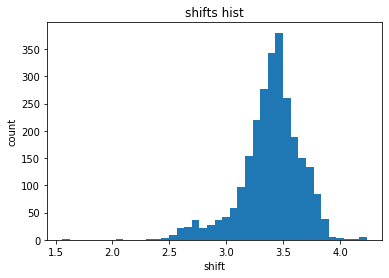

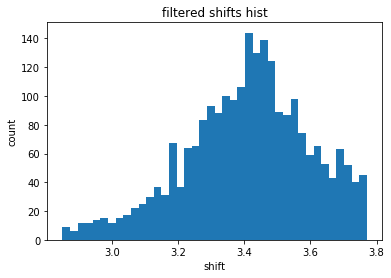

In [161]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Ignore center of the image

In [163]:
shift = 25
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.3)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [164]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [165]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 3.208879100550336 standart error: 0.0052362437975233345


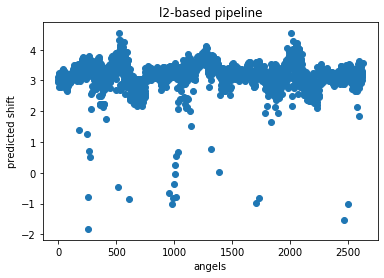

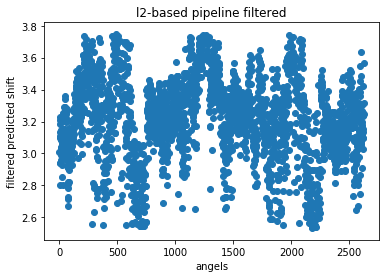

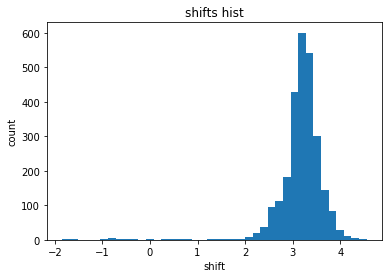

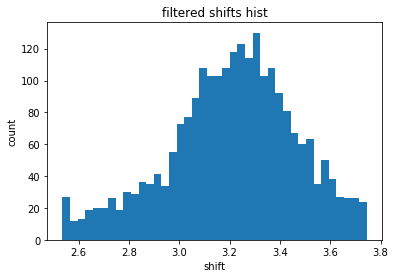

In [166]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Higher percent

In [167]:
shift = 25
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.5)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [168]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [169]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 2.9863192292727545 standart error: 0.008559084543741033


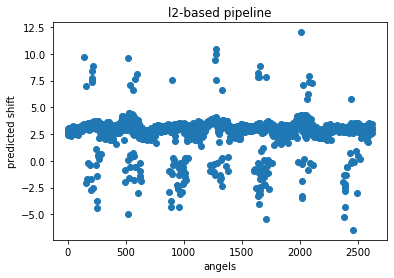

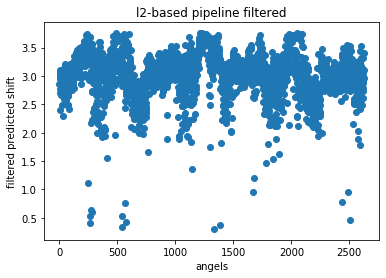

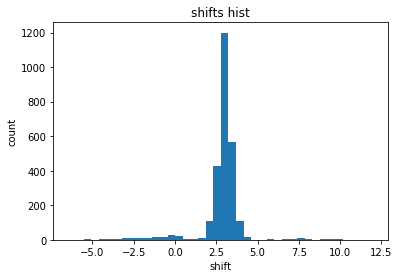

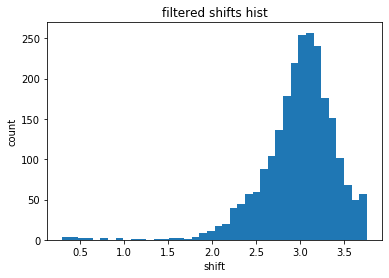

In [170]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Lower percent

In [171]:
shift = 25
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.1)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [172]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [173]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 3.355498440742281 standart error: 0.004133197369811288


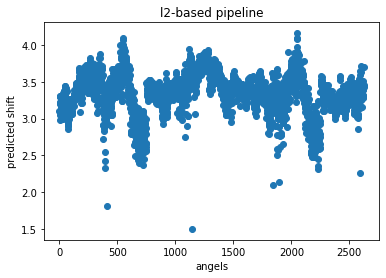

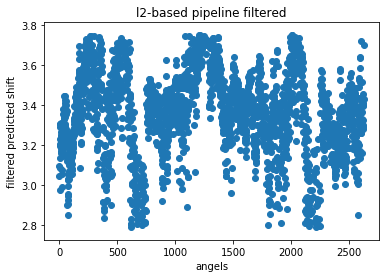

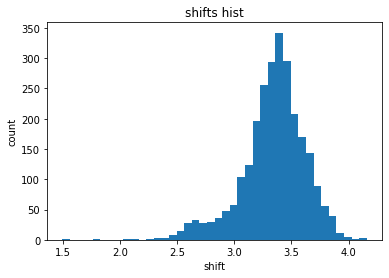

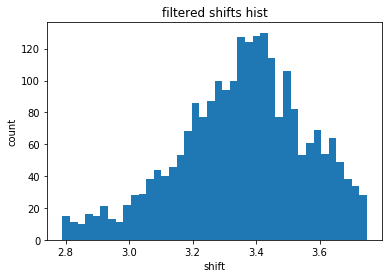

In [174]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Check l1

In [407]:
shift = 25
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, loss='l1', use_spline_minima=False)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [408]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [409]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 3.4119638826185104 standart error: 0.004046440384648962


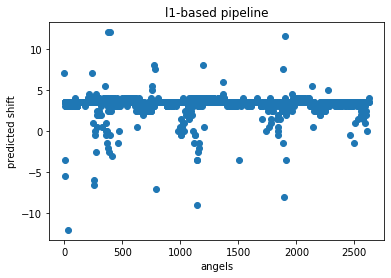

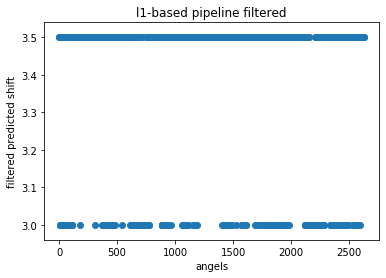

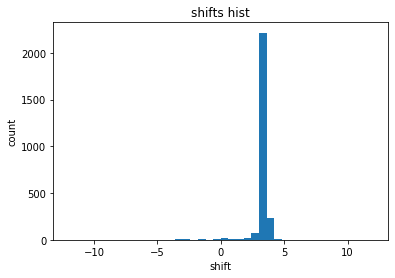

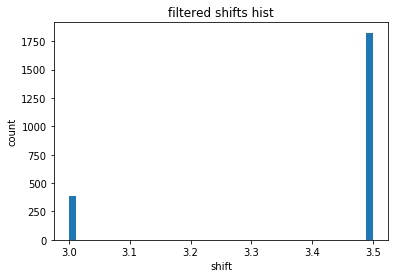

In [410]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l1-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l1-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Check some reconstructions

100%|██████████| 5/5 [27:38<00:00, 331.79s/it]


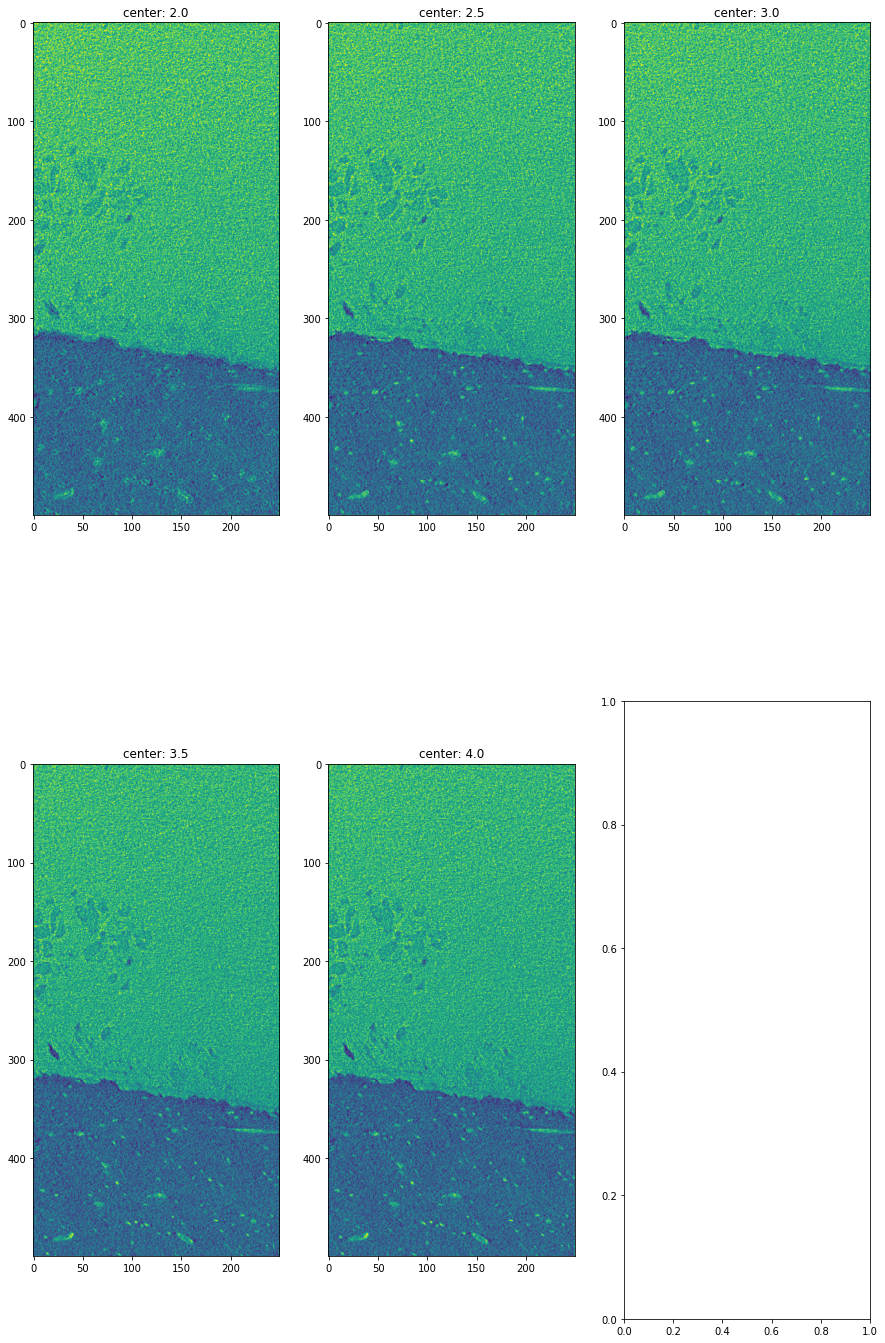

In [183]:
find_visual_best([2., 2.5, 3., 3.5, 4.], tiffs[0, :, :], angles.squeeze(), ncols=3, from_x=500, to_x=1000, from_y=750, to_y=1000)
plt.show()

100%|██████████| 5/5 [26:48<00:00, 321.66s/it]


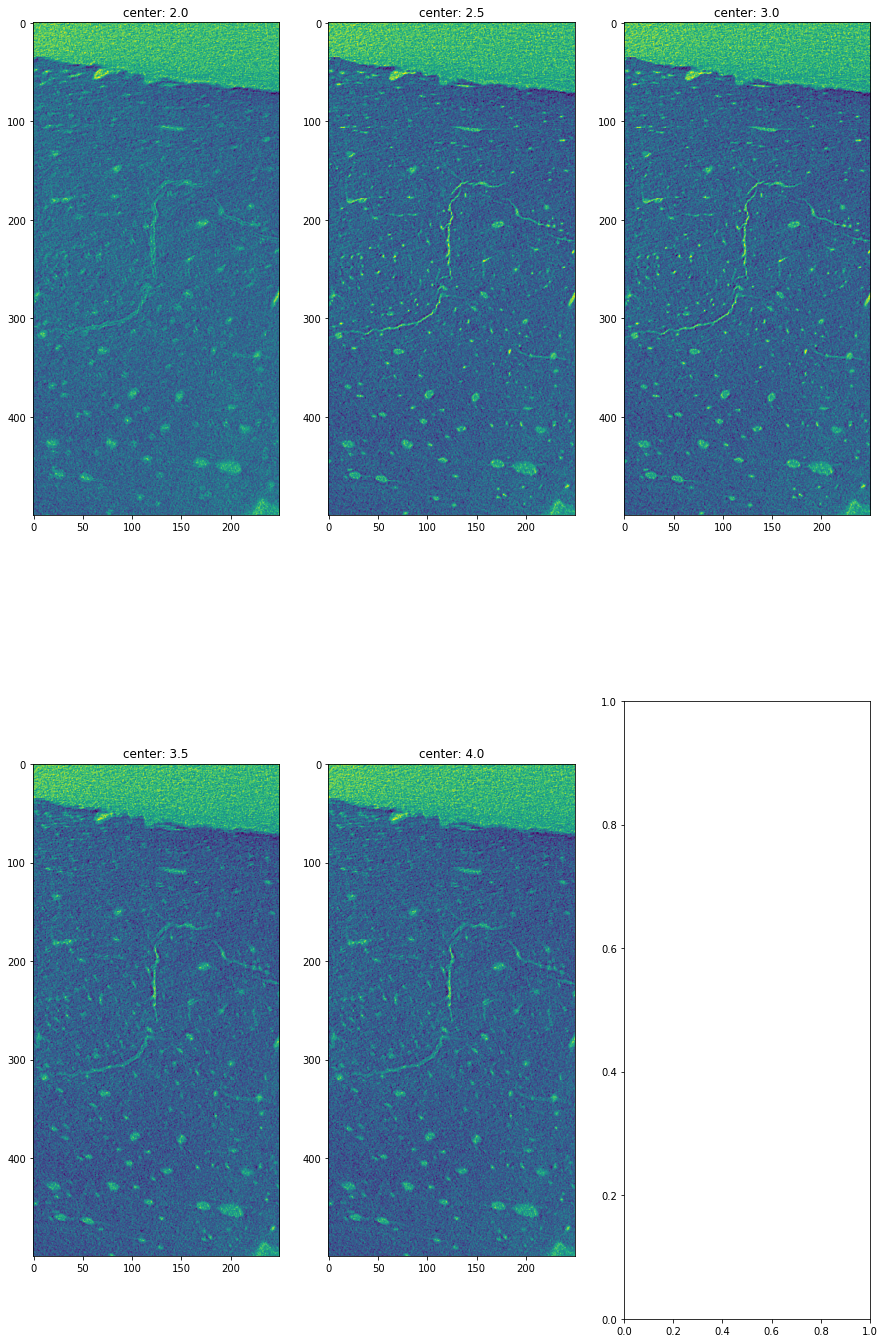

In [184]:
find_visual_best([2., 2.5, 3., 3.5, 4.], tiffs[366, :, :], angles.squeeze(), ncols=3, from_x=500, to_x=1000, from_y=750, to_y=1000)
plt.show()

## Try custom weight matrices